In [1]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy.special import gammaln

In [2]:
# Set global theme settings for plotting
plt.rcParams.update({
    'font.size': 20,          # Set font size
    'lines.linewidth': 3,     # Set default line thickness
    'axes.titlesize': 20,     # Title font size
    'axes.labelsize': 18,     # Axis label font size
    'xtick.labelsize': 14,    # X-tick label font size
    'ytick.labelsize': 14,    # Y-tick label font size
    'grid.color': 'gray',     # Grid color
    'grid.linestyle': '--',   # Grid line style
    'grid.linewidth': 0.5,    # Grid line width
    'legend.fontsize': 16     # Legend font size
})

colorslist = ['#1f77b4', '#ff7f0e', '#2ca02c']

In [3]:
Uds = np.array([0.1, 2.0, 5.0])
PopulationSize = [100, 1000, 10000]
human_popsize = 10000
sd = -10**(-np.linspace(1, 2.5, 10))
iterations = 1000

Kimetalsd = -0.009
Boykoetalsd = -0.029

#x is the number of segregating mutations per individual
xmean = -Uds[1]/sd
Kim_xmean = -Uds/Kimetalsd
Boyko_xmean = -Uds/Boykoetalsd


negative_relativeEepsilon = np.linspace(0.001, 1, 100)
positive_relativeEepsilon = -np.linspace(0.001, 1, 100)

Kim_xmean[0]



np.float64(11.111111111111112)

In [4]:
def get_min_max_poisson_sample(xmean, samplesize):
  """
  Generates a sample of a Poisson distribution. and spits the minimum value for this sample
  """
  sample = np.random.poisson(lam=xmean, size=samplesize)
  return np.min(sample), np.max(sample)

def get_expected_min_max_poisson_sample(xmean, samplesize, iterations):
  """
  Generates the expected minimum and standard error of iterations samples of Poisson distribution of size samplesize.
  """
  array_minx = []
  array_maxx = []
  for i in range(iterations):
    resultmin, resultmax = get_min_max_poisson_sample(xmean, samplesize)
    array_minx.append(resultmin)
    array_maxx.append(resultmax)

  mean_array_minx = np.mean(array_minx)
  std_dev_array_minx = np.std(array_minx)
  std_error_array_minx = std_dev_array_minx / np.sqrt(iterations)

  mean_array_maxx = np.mean(array_maxx)
  std_dev_array_maxx = np.std(array_maxx)
  std_error_array_maxx = std_dev_array_maxx / np.sqrt(iterations)

  return mean_array_minx, std_error_array_minx, mean_array_maxx, std_error_array_maxx

def get_expected_overA(xmean, xmin, xmax, relativeE_epsilon):
  result = 0
  if relativeE_epsilon != 0:
    for k in range(int(xmin), int(xmax+1)):
      floatk = float(k)
      probability_k = np.exp(floatk*np.log(xmean)-xmean - gammaln(k + 1))
      result += ((1.0+relativeE_epsilon)**floatk)*probability_k
    return result
  else:
    for k in range(int(xmin), int(xmax+1)):
      floatk = float(k)
      probability_k = np.exp(floatk*np.log(xmean)-xmean- gammaln(k + 1))
      result += floatk*probability_k
    return result

def get_growht_rate(segregating_mutations, meansegregating, minsegregating, maxsegregating, E_selectioncoeff, relativeE_epsilon):
  expected_term = get_expected_overA(meansegregating, minsegregating, maxsegregating, relativeE_epsilon)
  if relativeE_epsilon != 0:
    genotype_term = (1.0+relativeE_epsilon)**(segregating_mutations)
    rbest = -(E_selectioncoeff/relativeE_epsilon)*(expected_term-genotype_term)/(expected_term)
  else:
    rbest = -E_selectioncoeff*(expected_term-segregating_mutations)
  return rbest

def get_selective_deaths(meansegregating, minsegregating, maxsegregating, E_selectioncoeff, relativeE_epsilon):
  fitness_best = np.exp(get_growht_rate(minsegregating, meansegregating, minsegregating, maxsegregating, E_selectioncoeff, relativeE_epsilon))
  fraction_selective_deaths = 1.0-(1.0/fitness_best)
  return fraction_selective_deaths

def get_fitness(growth_rate):
  fitness = np.exp(growth_rate)
  return fitness

vget_expected_min_max_poisson_sample = np.vectorize(get_expected_min_max_poisson_sample)
vget_selective_deaths = np.vectorize(get_selective_deaths)

In [5]:
#Make a test of growth rate and selective deaths functions using Boyko et al sd and human Ud=2
expected_min_Kim, std_error_min_Kim, expected_max_Kim, std_error_max_Kim = get_expected_min_max_poisson_sample(Kim_xmean[1], human_popsize, iterations)
testepsilon = 0.01
print(expected_min_Kim)
print(get_growht_rate(expected_min_Kim, Kim_xmean[1], expected_min_Kim, expected_max_Kim, Kimetalsd, testepsilon))

print(Kim_xmean[1])
print(get_growht_rate(Kim_xmean[1], Kim_xmean[1], expected_min_Kim, expected_max_Kim, Kimetalsd, testepsilon))

print(expected_max_Kim)
print(get_growht_rate(expected_max_Kim, Kim_xmean[1], expected_min_Kim, expected_max_Kim, Kimetalsd, testepsilon))

print(get_selective_deaths(Kim_xmean[1], expected_min_Kim, expected_max_Kim, Kimetalsd, testepsilon))

167.405
0.3840272328920745
222.22222222222223
0.00974896502052206
281.941
-0.7127967806731305
0.3188871217465262


In [6]:
# Generate samples of min and max invidviduals with varying population sizes
expected_min_N0, std_error_min_N0, expected_max_N0, std_error_max_N0 = vget_expected_min_max_poisson_sample(xmean, PopulationSize[0], iterations)
expected_min_N1, std_error_min_N1, expected_max_N1, std_error_max_N1 = vget_expected_min_max_poisson_sample(xmean, PopulationSize[1], iterations)
expected_min_N2, std_error_min_N2, expected_max_N2, std_error_max_N2 = vget_expected_min_max_poisson_sample(xmean, PopulationSize[2], iterations)

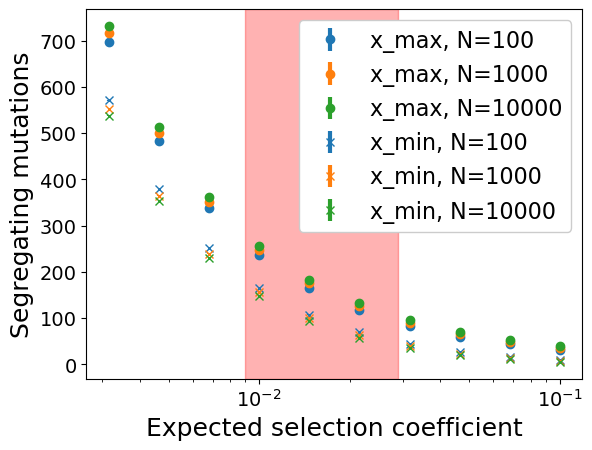

In [7]:
N_sizes = [str(PopulationSize[0]), str(PopulationSize[1]), str(PopulationSize[2])]

data_segregating = {
    (str(PopulationSize[0]), 'x_max'): (expected_max_N0, std_error_max_N0),
    (str(PopulationSize[1]), 'x_max'): (expected_max_N1, std_error_max_N1),
    (str(PopulationSize[2]), 'x_max'): (expected_max_N2, std_error_max_N2),
    (str(PopulationSize[0]), 'x_min'): (expected_min_N0, std_error_min_N0),
    (str(PopulationSize[1]), 'x_min'): (expected_min_N1, std_error_min_N1),
    (str(PopulationSize[2]), 'x_min'): (expected_min_N2, std_error_min_N2),
}

color_map = {str(PopulationSize[0]): '#1f77b4', str(PopulationSize[1]): '#ff7f0e', str(PopulationSize[2]): '#2ca02c'}
marker_map = {'x_max': 'o', 'x_min': 'x'}


for (N, value_type), (y, yerr) in data_segregating.items():
    plt.errorbar(-sd, y, yerr=yerr, fmt=marker_map[value_type], color=color_map[N], label=f'{value_type}, N={N}')

plt.xscale('log')
plt.xlabel('Expected selection coefficient')
plt.ylabel('Segregating mutations')
plt.axvspan(-Kimetalsd, -Boykoetalsd, color='r', alpha=0.3)
plt.legend(framealpha=1)
plt.savefig('graphs/Expectedminxmaxx.png', bbox_inches='tight') 

In [8]:
expected_min_Kim, std_error_min_Kim, expected_max_Kim, std_error_max_Kim = get_expected_min_max_poisson_sample(Kim_xmean[0], human_popsize, iterations)

mult_selective_deaths_Ud0 = get_selective_deaths(Kim_xmean[0], expected_min_Kim, expected_max_Kim, Kimetalsd, 0.0)
negative_epistais_selective_deaths_Ud0 = vget_selective_deaths(Kim_xmean[0], expected_min_Kim, expected_max_Kim, Kimetalsd, negative_relativeEepsilon)
positive_epistais_selective_deaths_Ud0 = vget_selective_deaths(Kim_xmean[0], expected_min_Kim, expected_max_Kim, Kimetalsd, positive_relativeEepsilon)


expected_min_Kim, std_error_min_Kim, expected_max_Kim, std_error_max_Kim = get_expected_min_max_poisson_sample(Kim_xmean[1], human_popsize, iterations)

mult_selective_deaths_Ud1 = get_selective_deaths(Kim_xmean[1], expected_min_Kim, expected_max_Kim, Kimetalsd, 0.0)
negative_epistais_selective_deaths_Ud1 = vget_selective_deaths(Kim_xmean[1], expected_min_Kim, expected_max_Kim, Kimetalsd, negative_relativeEepsilon)
positive_epistais_selective_deaths_Ud1 = vget_selective_deaths(Kim_xmean[1], expected_min_Kim, expected_max_Kim, Kimetalsd, positive_relativeEepsilon)

expected_min_Kim, std_error_min_Kim, expected_max_Kim, std_error_max_Kim = get_expected_min_max_poisson_sample(Kim_xmean[2], human_popsize, iterations)

mult_selective_deaths_Ud2 = get_selective_deaths(Kim_xmean[2], expected_min_Kim, expected_max_Kim, Kimetalsd, 0.0)
negative_epistais_selective_deaths_Ud2 = vget_selective_deaths(Kim_xmean[2], expected_min_Kim, expected_max_Kim, Kimetalsd, negative_relativeEepsilon)
positive_epistais_selective_deaths_Ud2 = vget_selective_deaths(Kim_xmean[2], expected_min_Kim, expected_max_Kim, Kimetalsd, positive_relativeEepsilon)

/tmp/ipykernel_51535/2647341759.py:48: RuntimeWarning: invalid value encountered in scalar divide
  rbest = -(E_selectioncoeff/relativeE_epsilon)*(expected_term-genotype_term)/(expected_term)


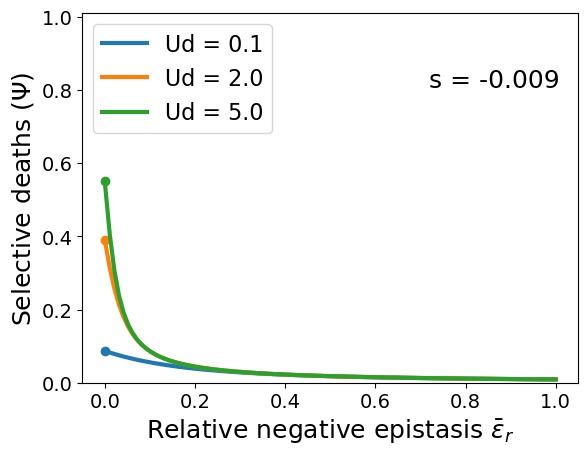

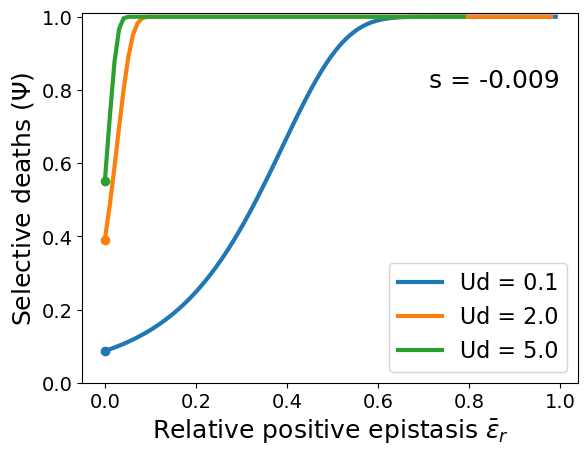

In [9]:
#x_locator = FixedLocator([0.000, 0.002, 0.004, 0.006, 0.008, 0.010])
#x_formatter = FixedFormatter(['0.000', '-0.002', '-0.004', '-0.006', '-0.008', '-0.010'])

fig = plt.figure()
ax = fig.gca()
ax.plot(negative_relativeEepsilon, negative_epistais_selective_deaths_Ud0, color = colorslist[0], label="Ud = " + str(Uds[0]))
ax.plot(0.0, mult_selective_deaths_Ud0, 'o', color=colorslist[0])
ax.plot(negative_relativeEepsilon, negative_epistais_selective_deaths_Ud1, color = colorslist[1], label="Ud = " + str(Uds[1]))
ax.plot(0.0, mult_selective_deaths_Ud1, 'o', color=colorslist[1])
ax.plot(negative_relativeEepsilon, negative_epistais_selective_deaths_Ud2, color = colorslist[2], label="Ud = " + str(Uds[2]))
ax.plot(0.0, mult_selective_deaths_Ud2, 'o', color=colorslist[2])
ax.legend()
ax.set_xlabel('Relative negative epistasis ' + r'$\bar{\epsilon}_r$')
ax.set_ylabel('Selective deaths ' + r'$(\Psi)$')
ax.set_ylim(0, 1.01)
ax.text(0.7, 0.8, "s = " + str(Kimetalsd), fontsize=18, transform=ax.transAxes)
#ax.xaxis.set_major_formatter(x_formatter)
#ax.xaxis.set_major_locator(x_locator)
fig.savefig('graphs/Selectivedeaths_Kimnegativeepistasis.png', bbox_inches='tight') 
plt.show(fig)
plt.close(fig)


fig = plt.figure()
ax = fig.gca()
ax.plot(-positive_relativeEepsilon, positive_epistais_selective_deaths_Ud0, color = colorslist[0], label="Ud = " + str(Uds[0]))
ax.plot(0.0, mult_selective_deaths_Ud0, 'o', color=colorslist[0])
ax.plot(-positive_relativeEepsilon, positive_epistais_selective_deaths_Ud1, color = colorslist[1], label="Ud = " + str(Uds[1]))
ax.plot(0.0, mult_selective_deaths_Ud1, 'o', color=colorslist[1])
ax.plot(-positive_relativeEepsilon, positive_epistais_selective_deaths_Ud2, color = colorslist[2], label="Ud = " + str(Uds[2]))
ax.plot(0.0, mult_selective_deaths_Ud2, 'o', color=colorslist[2])
ax.legend()
ax.set_xlabel('Relative positive epistasis ' + r'$\bar{\epsilon}_r$')
ax.set_ylabel('Selective deaths ' + r'$(\Psi)$')
ax.set_ylim(0, 1.01)
ax.text(0.7, 0.8, "s = " + str(Kimetalsd), fontsize=18, transform=ax.transAxes)
fig.savefig('graphs/Selectivedeaths_Kimpositiveepistasis.png', bbox_inches='tight') 
plt.show(fig)
plt.close(fig)


In [10]:
expected_min_Boyko, std_error_min_Boyko, expected_max_Boyko, std_error_max_Boyko = get_expected_min_max_poisson_sample(Boyko_xmean[0], human_popsize, iterations)

mult_selective_deaths_Ud0 = get_selective_deaths(Boyko_xmean[0], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, 0.0)
negative_epistais_selective_deaths_Ud0 = vget_selective_deaths(Boyko_xmean[0], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, negative_relativeEepsilon)
positive_epistais_selective_deaths_Ud0 = vget_selective_deaths(Boyko_xmean[0], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, positive_relativeEepsilon)


expected_min_Boyko, std_error_min_Boyko, expected_max_Boyko, std_error_max_Boyko = get_expected_min_max_poisson_sample(Boyko_xmean[1], human_popsize, iterations)

mult_selective_deaths_Ud1 = get_selective_deaths(Boyko_xmean[1], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, 0.0)
negative_epistais_selective_deaths_Ud1 = vget_selective_deaths(Boyko_xmean[1], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, negative_relativeEepsilon)
positive_epistais_selective_deaths_Ud1 = vget_selective_deaths(Boyko_xmean[1], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, positive_relativeEepsilon)

expected_min_Boyko, std_error_min_Boyko, expected_max_Boyko, std_error_max_Boyko = get_expected_min_max_poisson_sample(Boyko_xmean[2], human_popsize, iterations)

mult_selective_deaths_Ud2 = get_selective_deaths(Boyko_xmean[2], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, 0.0)
negative_epistais_selective_deaths_Ud2 = vget_selective_deaths(Boyko_xmean[2], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, negative_relativeEepsilon)
positive_epistais_selective_deaths_Ud2 = vget_selective_deaths(Boyko_xmean[2], expected_min_Boyko, expected_max_Boyko, Boykoetalsd, positive_relativeEepsilon)

/tmp/ipykernel_51535/2647341759.py:48: RuntimeWarning: invalid value encountered in scalar divide
  rbest = -(E_selectioncoeff/relativeE_epsilon)*(expected_term-genotype_term)/(expected_term)
/tmp/ipykernel_51535/2647341759.py:54: RuntimeWarning: overflow encountered in exp
  fitness_best = np.exp(get_growht_rate(minsegregating, meansegregating, minsegregating, maxsegregating, E_selectioncoeff, relativeE_epsilon))


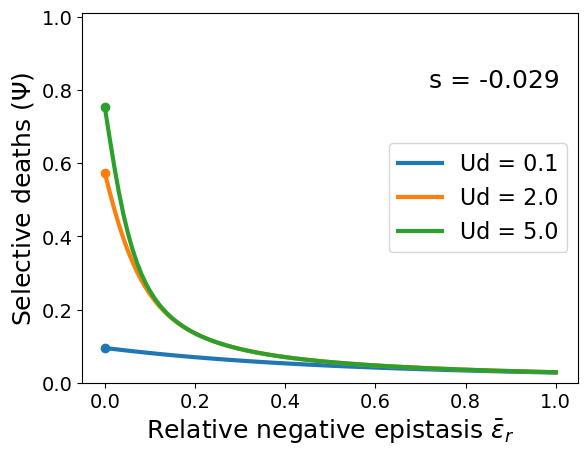

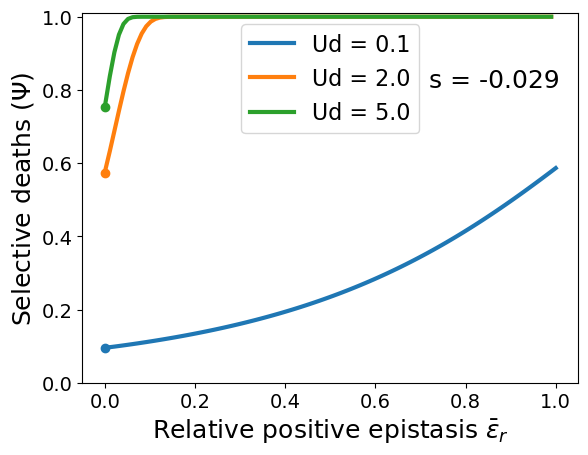

In [11]:
#x_locator = FixedLocator([0.000, 0.002, 0.004, 0.006, 0.008, 0.010])
#x_formatter = FixedFormatter(['0.000', '-0.002', '-0.004', '-0.006', '-0.008', '-0.010'])

fig = plt.figure()
ax = fig.gca()
ax.plot(negative_relativeEepsilon, negative_epistais_selective_deaths_Ud0, color = colorslist[0], label="Ud = " + str(Uds[0]))
ax.plot(0.0, mult_selective_deaths_Ud0, 'o', color=colorslist[0])
ax.plot(negative_relativeEepsilon, negative_epistais_selective_deaths_Ud1, color = colorslist[1], label="Ud = " + str(Uds[1]))
ax.plot(0.0, mult_selective_deaths_Ud1, 'o', color=colorslist[1])
ax.plot(negative_relativeEepsilon, negative_epistais_selective_deaths_Ud2, color = colorslist[2], label="Ud = " + str(Uds[2]))
ax.plot(0.0, mult_selective_deaths_Ud2, 'o', color=colorslist[2])
ax.legend()
ax.set_xlabel('Relative negative epistasis ' + r'$\bar{\epsilon}_r$')
ax.set_ylabel('Selective deaths ' + r'$(\Psi)$')
ax.set_ylim(0, 1.01)
ax.text(0.7, 0.8, "s = " + str(Boykoetalsd), fontsize=18, transform=ax.transAxes)
#ax.xaxis.set_major_formatter(x_formatter)
#ax.xaxis.set_major_locator(x_locator)
fig.savefig('graphs/Selectivedeaths_Boykonegativeepistasis.png', bbox_inches='tight') 
plt.show(fig)
plt.close(fig)


fig = plt.figure()
ax = fig.gca()
ax.plot(-positive_relativeEepsilon, positive_epistais_selective_deaths_Ud0, color = colorslist[0], label="Ud = " + str(Uds[0]))
ax.plot(0.0, mult_selective_deaths_Ud0, 'o', color=colorslist[0])
ax.plot(-positive_relativeEepsilon, positive_epistais_selective_deaths_Ud1, color = colorslist[1], label="Ud = " + str(Uds[1]))
ax.plot(0.0, mult_selective_deaths_Ud1, 'o', color=colorslist[1])
ax.plot(-positive_relativeEepsilon, positive_epistais_selective_deaths_Ud2, color = colorslist[2], label="Ud = " + str(Uds[2]))
ax.plot(0.0, mult_selective_deaths_Ud2, 'o', color=colorslist[2])
ax.legend()
ax.set_xlabel('Relative positive epistasis ' + r'$\bar{\epsilon}_r$')
ax.set_ylabel('Selective deaths ' + r'$(\Psi)$')
ax.set_ylim(0, 1.01)
ax.text(0.7, 0.8, "s = " + str(Boykoetalsd), fontsize=18, transform=ax.transAxes)
fig.savefig('graphs/Selectivedeaths_Boykopositiveepistasis.png', bbox_inches='tight') 
plt.show(fig)
plt.close(fig)